# Section 2.3.3: DeepHit (Single Event) Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepHit (Lee et al., 2018) specialized to working with a single critical event (as in Example 2.3.1 of the monograph) with the help of PyCox and PyTorch. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

In this demo, we specifically use PyCox's `DeepHitSingle` model (which is a Python class). Here, the word "single" shows up since we are using DeepHit with a single critical event of interest (in general, DeepHit handles competing risks, for which there is more than just a single critical event of interest).

As discussed in the monograph, DeepHit is inherently a discrete time model that requires that we specify what time grid to use, so when we set up the data to be used with PyTorch training, there's an extra step of setting up a time grid and discretizing the observed times seen in the training and validation data.

*Disclaimer:* Note that PyCox actually uses various conventions that are not standard in terms of working with PyTorch (it relies heavily on another package `torchtuples` by the same author as PyCox). Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does *not* perfectly align with the demos that come with PyCox but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). The key reason why we stick to standard PyTorch conventions is so that the code makes various preprocessing and model training steps more transparent, so that if you want to modify any part of these, it should be easier to do so (for instance, if you want to introduce a specific learning rate schedule, if you want to add early stopping based on a validation set integrated Brier score, if you want to control for randomness in a particular way using your own data loaders or specific random number generators, etc).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

We use PyCox's provided `LabTransDiscreteTime` class that helps discretize time. Note that there are many ways to discretize time (see Section 2.3.2 of the monograph). Here, we are only implementing two ways (using all unique times of death, or discretizing based on some user-specified number of quantiles).

In [3]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used.

In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepHit model and loss

We are now ready to set up the DeepHit model using PyCox's `DeepHitSingle` class. Note that PyCox's implementation of DeepHit does *not* require that what we call `base_neural_net` outputs valid probability distributions. The reason is that under the hood, when it computes the DeepHit loss, it actually applies a softmax activation right after the base neural net (specifically, it applies equation (9) of Kvamme and Borgan (2021)).

As we shall see later in the demo, the `DeepHitSingle` class provides various helper functions such as predicting survival functions for test data and interpolating these survival functions so that they use a higher time resolution than what we specified in `time_grid_train_np`.

In [5]:
import torch.nn as nn
from pycox.models import DeepHitSingle

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, output_num_time_steps)).to(device)  # no softmax needed at the end

# setting alpha=1.0 means that we only use the negative log likelihood loss and not also the ranking loss
# (we do this just as an illustrative example as it corresponds to how DeepHit is first presented in
# Example 2.3.1 of the monograph)
deephit_model = DeepHitSingle(base_neural_net, alpha=1.0, device=device,
                              duration_index=time_grid_train_np)
deephit_loss = deephit_model.loss  # we'll see how to use this loss function in the next code cell

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [6]:
from copy import deepcopy
from torch.utils.data import DataLoader
from pycox.models.data import pair_rank_mat

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)

        # note that the loss function requires a ranking matrix to be specified;
        # this is specific to the ranking loss that we are actually not using in this
        # particular demo (but we leave this here since one could modify the demo
        # easily to also be using the ranking loss, in which case this ranking matrix
        # will be needed)
        rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
        rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)

        loss_batch = deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            train_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            val_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 3.916062831878662 - val loss 3.9150960445404053
Epoch 2 - train loss 3.893968343734741 - val loss 3.8937888145446777
Epoch 3 - train loss 3.8696820735931396 - val loss 3.8713314533233643
Epoch 4 - train loss 3.8404693603515625 - val loss 3.8450794219970703
Epoch 5 - train loss 3.8037173748016357 - val loss 3.8098793029785156
Epoch 6 - train loss 3.7631115913391113 - val loss 3.7702183723449707
Epoch 7 - train loss 3.720085859298706 - val loss 3.726944923400879
Epoch 8 - train loss 3.682729959487915 - val loss 3.689936399459839
Epoch 9 - train loss 3.652803421020508 - val loss 3.6605794429779053
Epoch 10 - train loss 3.6299426555633545 - val loss 3.6373839378356934
Epoch 11 - train loss 3.6132731437683105 - val loss 3.621795892715454
Epoch 12 - train loss 3.5998377799987793 - val loss 3.609221935272217
Epoch 13 - train loss 3.5890932083129883 - val loss 3.6000239849090576
Epoch 14 - train loss 3.5805885791778564 - val loss 3.592714309692383
Epoch 15 - train loss 3.5

<All keys matched successfully>

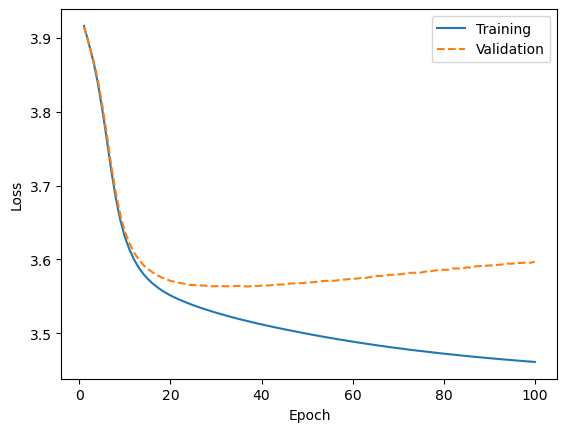

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [8]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [9]:
surv_test_np = deephit_model.predict_surv(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
surv_test_np.shape

(2662, 109)

Note that the time grid used is precisely the one stored in `time_grid_train_np`:

In [10]:
len(time_grid_train_np)

109

PyCox provides a helper function `predict_surv_df` that gets both the time grid and the predicted survival functions into a Pandas DataFrame. Note that for this DataFrame, the rows correspond to time and columns correspond to the different test points.

In [11]:
surv_test_df = deephit_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
0.0,0.999981,0.999319,0.999421,0.998916,0.999944,0.999988,0.999029,0.999091,0.999518,0.999997,...,0.999942,0.999892,0.998878,0.998989,0.999961,0.998592,0.999974,0.999376,0.997172,0.999805
3.0,0.966386,0.990079,0.989549,0.991190,0.986691,0.996840,0.990878,0.992223,0.994270,0.996848,...,0.989032,0.997803,0.991950,0.991956,0.997363,0.987516,0.996628,0.991377,0.988204,0.970640
4.0,0.872919,0.954802,0.972472,0.978045,0.965564,0.967528,0.976661,0.979665,0.980709,0.970878,...,0.972543,0.972053,0.978847,0.978636,0.982502,0.974065,0.962700,0.955129,0.974229,0.936413
5.0,0.820099,0.919456,0.958270,0.964234,0.953248,0.923308,0.965408,0.966981,0.963457,0.939818,...,0.960980,0.932772,0.963786,0.966515,0.963416,0.961725,0.910919,0.915803,0.960137,0.919683
6.0,0.744638,0.888553,0.949304,0.954284,0.944417,0.894503,0.956138,0.958616,0.953538,0.919636,...,0.952272,0.917319,0.953391,0.958142,0.952575,0.951420,0.872813,0.884279,0.947830,0.908099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,0.260584,0.100707,0.116248,0.088784,0.337562,0.502196,0.103488,0.100280,0.135626,0.665883,...,0.341956,0.260377,0.090854,0.096821,0.439469,0.079623,0.386224,0.104125,0.061292,0.154872
1690.0,0.257719,0.093857,0.107055,0.079984,0.328262,0.498289,0.093525,0.091284,0.126850,0.663059,...,0.333463,0.255011,0.081370,0.087851,0.432493,0.069468,0.381994,0.098139,0.052284,0.145442
1760.0,0.251844,0.082882,0.098280,0.071199,0.320292,0.495036,0.079171,0.082216,0.120120,0.661010,...,0.326241,0.246574,0.074152,0.076273,0.426117,0.061536,0.376748,0.088860,0.042003,0.137495
1813.0,0.245281,0.071562,0.092644,0.064950,0.311957,0.486170,0.068015,0.075951,0.113942,0.655532,...,0.318321,0.237883,0.068123,0.068728,0.415024,0.055502,0.364445,0.079687,0.034986,0.132789


If you want to interpolate, PyCox provides the following interpolation functionality:

In [12]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = deephit_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_interp_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
0.0,0.999981,0.999319,0.999421,0.998916,0.999944,0.999988,0.999029,0.999091,0.999518,0.999997,...,0.999942,0.999892,0.998878,0.998989,0.999961,0.998592,0.999974,0.999376,0.997172,0.999805
0.3,0.996622,0.998395,0.998434,0.998143,0.998619,0.999673,0.998214,0.998404,0.998993,0.999682,...,0.998851,0.999683,0.998186,0.998286,0.999701,0.997485,0.999639,0.998576,0.996275,0.996888
0.6,0.993262,0.997471,0.997447,0.997371,0.997293,0.999359,0.997399,0.997717,0.998468,0.999367,...,0.997760,0.999475,0.997493,0.997583,0.999441,0.996377,0.999305,0.997776,0.995378,0.993972
0.9,0.989903,0.996547,0.996460,0.996598,0.995968,0.999044,0.996584,0.997031,0.997944,0.999052,...,0.996669,0.999266,0.996800,0.996879,0.999181,0.995269,0.998970,0.996976,0.994481,0.991055
1.2,0.986543,0.995623,0.995472,0.995826,0.994643,0.998729,0.995768,0.996344,0.997419,0.998737,...,0.995578,0.999057,0.996107,0.996176,0.998922,0.994162,0.998635,0.996176,0.993585,0.988139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942.6,0.102042,0.034743,0.043012,0.032016,0.129998,0.198041,0.033382,0.036269,0.051427,0.264587,...,0.132473,0.100452,0.033074,0.033503,0.170541,0.028092,0.150072,0.037519,0.020077,0.059038
1964.2,0.078169,0.028607,0.034740,0.026527,0.099671,0.150019,0.027610,0.029655,0.041008,0.199429,...,0.101498,0.077547,0.027233,0.027632,0.129794,0.023524,0.114343,0.030491,0.017592,0.046746
1985.8,0.054296,0.022470,0.026468,0.021038,0.069345,0.101997,0.021838,0.023041,0.030589,0.134272,...,0.070524,0.054642,0.021392,0.021761,0.089047,0.018955,0.078614,0.023463,0.015107,0.034454
2007.4,0.030423,0.016334,0.018197,0.015549,0.039019,0.053976,0.016066,0.016428,0.020170,0.069114,...,0.039549,0.031737,0.015550,0.015890,0.048300,0.014387,0.042886,0.016435,0.012622,0.022162


In [13]:
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

We point out that if one did not want to create a Pandas DataFrame first, then the following code could be used instead to produce the same interpolated time grid and interpolated survival function:

```
surv_test_interp_np = deephit_model.interpolate(interpolation_factor).predict_surv(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
from pycox.models.utils import make_subgrid
time_grid_train_interp_np = np.array(make_subgrid(time_grid_train_np, interpolation_factor))
```

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

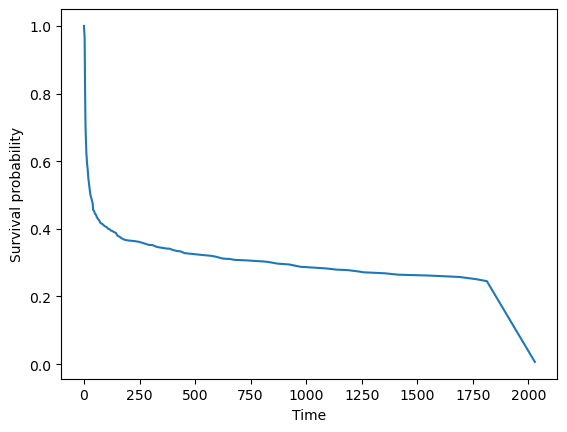

In [14]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

Here, we use the interpolated survival functions (along with their corresponding interpolated time grid).

As for choosing evaluation times, we still pick these based on the test set's observed times.

In [15]:
time_grid_test_np = np.unique(Y_test_np)

Since DeepHit does not make the proportional hazards assumption and can predict survival curves without shape constraints, Harrell's concordance index (Harrell et al., 1982) is not a valid evaluation metric to use.

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [16]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6088737721195845


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [17]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5952383597241816
Eval time 693.0 - truncated time-dependent concordance: 0.594074585623196
Eval time 1291.0 - truncated time-dependent concordance: 0.593412206245962


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [18]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6608183075900862
Eval time 693.0 - time-dependent AUC: 0.6946235312512404
Eval time 1291.0 - time-dependent AUC: 0.6953979312826533


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [19]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.23129584902500178
Eval time 693.0 - Brier score: 0.2082869725085887
Eval time 1291.0 - Brier score: 0.18742686043310824
Integrated Brier score: 0.19032579653742368


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [20]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [21]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 598.4784722301928


In [22]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 716.2569627330386
